In [109]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [110]:
# get the data of eurusd for given range
eur_usd_data_daily = yf.download('EURUSD=X', start='2005-01-01', end='2024-05-01')
eur_usd_data_monthly = yf.download('EURUSD=X', start='2005-01-01', end='2024-05-01', interval='1mo')

eur_usd_data_monthly.head(5)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-01,1.356594,1.362695,1.293193,1.305193,1.305193,0
2005-02-01,1.305006,1.328004,1.273707,1.321702,1.321702,0
2005-03-01,1.321895,1.347909,1.286107,1.296697,1.296697,0
2005-04-01,1.296798,1.311699,1.277906,1.292307,1.292307,0
2005-05-01,1.292307,1.298701,1.229997,1.230800,1.230800,0


In [111]:
# create a new dataframe to store the monthly data, indexes should be at the format: "2005-01"
feature_set = pd.DataFrame(index=eur_usd_data_daily.resample('M').mean().index.strftime('%Y-%m'), columns=['volatility'])

# calculate the volatility for each month
for month in feature_set.index:
    start_date = month
    end_date = pd.to_datetime(start_date) + pd.DateOffset(months=1)
    feature_set.loc[month] = round((eur_usd_data_daily.loc[start_date:end_date].Close.std()) * (len(eur_usd_data_daily.loc[start_date:end_date]) ** (1/2)) * 100, 3)

# print the monthly data
display(feature_set)

,volatility
Date,
2005-01,5.857
2005-02,7.158
2005-03,9.594
2005-04,3.802
2005-05,9.314
...,...
2023-12,5.198
2024-01,3.108
2024-02,1.903


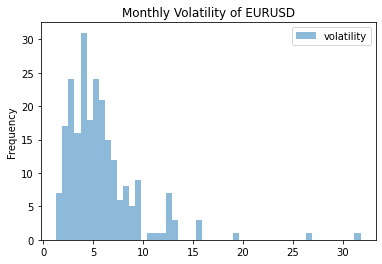

Mean: 5.7831250000000045
Standard Deviation: 3.705124144168627
Number of months that have volatility smaller than 6: 154


In [112]:
# make a histogram of the monthly volatility
feature_set.plot.hist(bins=50, alpha=0.5, title='Monthly Volatility of EURUSD')
plt.show()

# mean and standard deviation of the monthly volatility
mean = feature_set.volatility.mean()
std = feature_set.volatility.std()
print('Mean:', mean)
print('Standard Deviation:', std)

# print the ncount of the rows that are smaller than the mean + 1 std
threshold = 6
print(f'Number of months that have volatility smaller than {threshold}:', len(feature_set[feature_set.volatility < threshold]))

In [113]:
# add a low/high column that labels the month as low or high volatility according to the threshold
feature_set['low/high'] = np.where(feature_set.volatility < threshold, 0, 1)

# print the monthly data with the low/high column
feature_set.head(10)

,volatility,low/high
Date,,
2005-01,5.857,0
2005-02,7.158,1
2005-03,9.594,1
2005-04,3.802,0
2005-05,9.314,1
2005-06,4.344,0
2005-07,4.206,0
2005-08,4.595,0
2005-09,8.196,1


In [114]:
# adding related features to the monthly data

# add the percentage change of the previous month
feature_set['abs_pct_change_monthly'] = abs(np.array(eur_usd_data_monthly['Close'].pct_change()))

feature_set.head(10)

,volatility,low/high,abs_pct_change_monthly
Date,,,
2005-01,5.857,0,NaN
2005-02,7.158,1,0.012649
2005-03,9.594,1,0.018919
2005-04,3.802,0,0.003386
2005-05,9.314,1,0.047595
2005-06,4.344,0,0.017629
2005-07,4.206,0,0.002728
2005-08,4.595,0,0.017894
2005-09,8.196,1,0.025355


In [115]:
current_month = eur_usd_data_daily.index[0].strftime('%Y-%m')
prices = []

pct_dict = {}

for idx, daily in eur_usd_data_daily.iterrows():
    if current_month != idx.strftime('%Y-%m'):
        pct_dict[current_month] = max(abs(pd.Series(prices).pct_change().max()), abs(pd.Series(prices).pct_change().min()))
        prices = []
        current_month = idx.strftime('%Y-%m')
    else:
        prices.append(daily["Close"])


# adding the values to the feature set
feature_set['max_abs_return_daily'] = feature_set.index.map(pct_dict)

feature_set.head(10)

,volatility,low/high,abs_pct_change_monthly,max_abs_return_daily
Date,,,,
2005-01,5.857,0,NaN,0.013959
2005-02,7.158,1,0.012649,0.015078
2005-03,9.594,1,0.018919,0.012082
2005-04,3.802,0,0.003386,0.011495
2005-05,9.314,1,0.047595,0.014019
2005-06,4.344,0,0.017629,0.014870
2005-07,4.206,0,0.002728,0.013343
2005-08,4.595,0,0.017894,0.011570
2005-09,8.196,1,0.025355,0.009661


In [116]:
# splitting the data into x and y
y_data = feature_set['low/high']
x_data = feature_set.drop('low/high', axis=1)

